<a href="https://colab.research.google.com/github/Sravani9544/projects/blob/main/AppliedAICourse_Assignments/03_Amazon_Fine_Food_Reviews_Analysis_KNN_(1_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect (r'D:\python\database.sqlite') 


# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text
FROM Reviews
GROUP BY UserId
""", con)

In [ ]:
print(display.shape)
display.head()

(256059, 6)


,UserId,ProductId,ProfileName,Time,Score,Text
0,#oc-R103C0QSV1DF5E,B006Q820X0,C,1343088000,5,I have to say I was a little apprehensive to b...
1,#oc-R109MU5OBBZ59U,B008I1XPKA,AayGee,1350086400,5,Received my free K cups as a sample promotion ...
2,#oc-R10LFEMQEW6QGZ,B008I1XPKA,Julie,1345939200,5,Brooklyn Bean Roastery Blend K-Cups are great ...
3,#oc-R10LT57ZGIB140,B0026LJ3EA,dipr,1310601600,3,The shipment of the dog food was quick. Howev...
4,#oc-R10UA029WVWIUI,B006Q820X0,Kim D,1342483200,1,"Brooklyn ""French Roast"" K-Cup Coffee is not on..."


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text
255953,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:27<00:00, 2474.98it/s]


In [ ]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [ ]:
data_pos = final[final["Score"]== 1].sample(n=50000)
data_neg = final[final["Score"]== 0].sample(n=50000)
final_2000 = pd.concat([data_pos,data_neg])

In [ ]:
final_2000.shape

(100000, 10)

In [ ]:
final_2000["Time"] = pd.to_datetime(final_2000["Time"], unit = "s")
final_2000 = final_2000.sort_values(by = "Time")

<h2><font color='black'>[3.2] splitting of data </font></h2>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X = final_2000['Text']
X.shape
Y = final_2000['Score']
Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33) # this is random splitting

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("some feature names ", count_vect.get_feature_names()[:10])
print("the type of count vectorizer", type(X_train_bow))
print("the shape of out text BOW vectorizer", X_train_bow.get_shape())
print("the number of unique words", X_train_bow.get_shape()[1])
print('='*50)

some feature names  ['00', '000', '000001', '000mg', '001', '001bru', '00202', '005', '0060928115', '0069615']
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (44890, 42844)
the number of unique words 42844


In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data = StandardScaler(with_mean = False).fit_transform(X_train_bow)
std_data.shape

C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(44890, 42844)

In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data_test = StandardScaler(with_mean = False).fit_transform(X_test_bow)
std_data_test.shape

C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(33000, 42844)

In [ ]:
std_data_cv = StandardScaler(with_mean = False).fit_transform(X_cv_bow)
std_data_cv.shape

C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(22110, 42844)

In [ ]:
std_data = std_data.todense()
type(std_data)

In [ ]:
print("After bow")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*50)

After bow
(44890, 42844) (44890,)
(22110, 42844) (22110,)
(33000, 42844) (33000,)


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (44890, 5000)
the number of unique words including both unigrams and bigrams  5000


In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\srava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(44890, 5000)

In [ ]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [ ]:
std_data = std_data.todense()
type(std_data)

numpy.matrix

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['00', '00 and', '00 at', '00 box', '00 br', '00 can', '00 for', '00 in', '00 per', '000']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (44890, 50105)
the number of unique words including both unigrams and bigrams  50105


In [ ]:
X_train_tfidf = final_tf_idf

In [ ]:
X_train_tfidf.shape

(44890, 50105)

In [ ]:
X_test_tfidf = tf_idf_vect.transform(X_test)
X_test_tfidf.shape

(33000, 50105)

In [ ]:
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_cv_tfidf.shape

(22110, 50105)

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.8987786769866943), ('good', 0.8620812892913818), ('fantastic', 0.8470150828361511), ('perfect', 0.8161282539367676), ('special', 0.7535710334777832), ('delicious', 0.7444693446159363), ('decent', 0.7348847985267639), ('nice', 0.7342046499252319), ('excellent', 0.7040228247642517), ('awesome', 0.6961106657981873)]
[('best', 0.8548955917358398), ('saltiest', 0.7628551721572876), ('nastiest', 0.7364858388900757), ('WORST', 0.7031397819519043), ('hottest', 0.6817453503608704), ('worst-tasting', 0.6805601119995117), ('ever', 0.670866072177887), ('strangest', 0.6608849167823792), ('closest', 0.6577369570732117), ('BEST', 0.6524950265884399)]


In [ ]:
# X_test = vectorizer.transform(test['Contents'])

In [ ]:
w2v_model= Word2Vec(list_of_sentance_train, min_count= 5, size = 50,workers = 4)

In [ ]:
len(list_of_sentance_train)

44890

In [ ]:
print(final_2000['Text'].values[0])
print('*********')
print(list_of_sentance_train[0])

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
*********
['Shipper', 'was', 'fantastic', 'and', 'I', 'got', 'item', 'almost', 'next', 'day.', 'The', 'curry', 'paste', 'is', 'delicious!!']


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  26436
sample words  ['was', 'fantastic', 'and', 'I', 'got', 'item', 'almost', 'next', 'day.', 'The', 'curry', 'paste', 'is', 'delicious!!', "I've", 'always', 'enjoyed', 'the', 'decaf', 'at', 'a', 'little', 'Italian', 'restaurant', 'in', 'our', 'area.', 'noticed', 'that', 'their', 'affiliated', 'deli', 'sold', 'asked', 'if', 'what', 'they', 'brewed', 'for', 'told', 'yes.', 'immediately', 'went', 'to', 'Amazon', 'ordered', 'am', 'not', 'sorry.', 'What']


In [ ]:
w2v_model.wv.most_similar('like')

[('like,', 0.6825273036956787),
 ('like.', 0.653648853302002),
 ('okay', 0.5548310279846191),
 ('prefer', 0.5434665083885193),
 ('mean', 0.538202166557312),
 ('think', 0.5379892587661743),
 ('enjoy', 0.5210680961608887),
 ('good,', 0.5173327922821045),
 ('plain', 0.5157830715179443),
 ('expect', 0.5063368678092957)]

In [ ]:
i = 0
list_of_sent_test = []
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [ ]:
len(list_of_sent_test)

33000

In [ ]:
i = 0
list_of_sent_cv = []
for sent in X_cv:
    list_of_sent_cv.append(sent.split())

In [ ]:
len(list_of_sent_cv)

22110

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [08:19<00:00, 89.86it/s]


44890
50


In [ ]:
X_train_avgw2v = sent_vectors

In [ ]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [06:12<00:00, 88.63it/s]


33000
50


In [ ]:
X_test_avgw2v = sent_vectors_test

In [ ]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [04:26<00:00, 83.00it/s]


22110
50


In [ ]:
X_cv_avgw2v = sent_vectors_cv

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
tfidf_feat = model.get_feature_names() 
tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [42:43<00:00, 20.21it/s]


In [ ]:
X_train_tfidfw2v = tfidf_sent_vectors

In [ ]:
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sent_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 33000/33000 [5:38:48<00:00,  1.62it/s]


In [ ]:
X_test_tfidfw2v = tfidf_sent_vectors_test

In [ ]:
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sent_cv): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [38:45<00:00, 21.21it/s]


In [ ]:
X_cv_tfidfw2v = tfidf_sent_vectors_cv

## hyperparameter tuning with random search or grid search

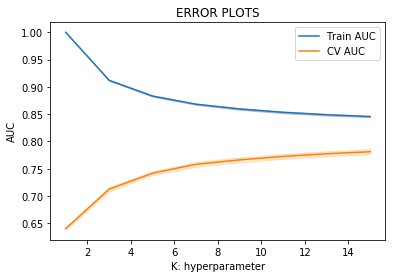

In [ ]:
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 3 , 5 , 7 , 9 , 11 , 13 , 15]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_bow, Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

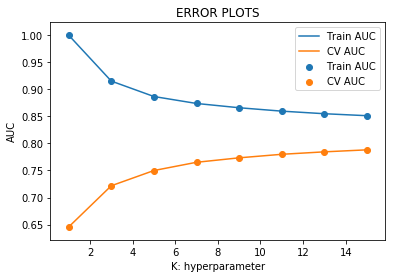

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'brute')
    neigh.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3,algorithm = 'brute')

In [ ]:
knn.fit(X_train_bow,Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test_bow)
print(pred)

[0 1 0 ... 1 1 1]


In [ ]:
pred1 = neigh.predict(X_train_bow)
print(pred1)

[1 1 1 ... 1 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 8718,  7628],
       [ 3414, 13240]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)

In [ ]:
cm1

array([[12869,  9691],
       [ 2419, 19911]], dtype=int64)

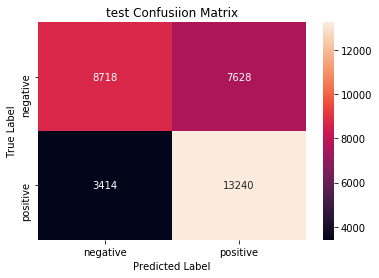

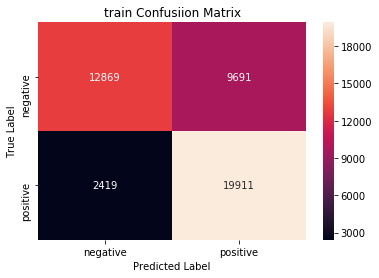

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("train classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.72      0.53      0.61     16346
           1       0.63      0.80      0.71     16654

   micro avg       0.67      0.67      0.67     33000
   macro avg       0.68      0.66      0.66     33000
weighted avg       0.68      0.67      0.66     33000

test classification report
              precision    recall  f1-score   support

           0       0.84      0.57      0.68     22560
           1       0.67      0.89      0.77     22330

   micro avg       0.73      0.73      0.73     44890
   macro avg       0.76      0.73      0.72     44890
weighted avg       0.76      0.73      0.72     44890



#### since f1 - score of both positive and negative points of train data is grater than that of test data , 
#### so precision and recall of train data are better  

In [ ]:
from sklearn.metrics import roc_curve

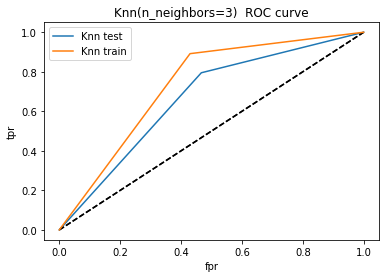

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### by looking at the roc curve we can say that both the test and train the model is better for both of them 
#### it is slightly better for train data

#### auc of test data = 0.8
#### auc of train data ~ 0.89

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

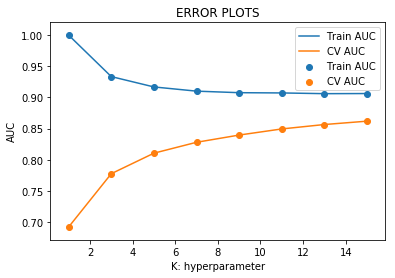

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'brute')
    neigh.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='brute')

In [ ]:
knn.fit(X_train_tfidf,Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test_tfidf)
print(pred)

[0 0 1 ... 1 1 0]


In [ ]:
pred1 = neigh.predict(X_train_tfidf)
print(pred1)

[0 1 0 ... 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[12216,  4130],
       [ 5021, 11633]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[18907,  3653],
       [ 4263, 18067]], dtype=int64)

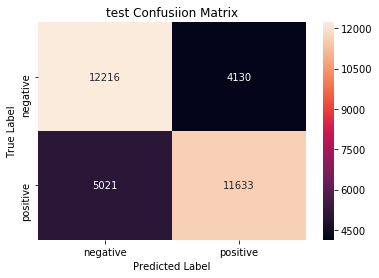

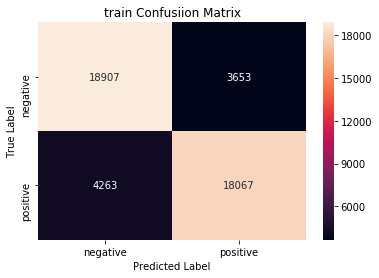

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.71      0.75      0.73     16346
           1       0.74      0.70      0.72     16654

   micro avg       0.72      0.72      0.72     33000
   macro avg       0.72      0.72      0.72     33000
weighted avg       0.72      0.72      0.72     33000

test classification report
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     22560
           1       0.83      0.81      0.82     22330

   micro avg       0.82      0.82      0.82     44890
   macro avg       0.82      0.82      0.82     44890
weighted avg       0.82      0.82      0.82     44890



#### since f1 - score of both positive and negative points of train data is grater than that of test data ,
#### so precision and recall of train data are better

In [ ]:
from sklearn.metrics import roc_curve

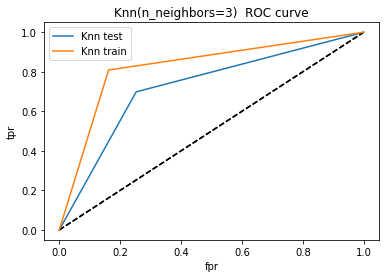

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### as roc curves of train and test are above the diagonal ,
#### we can say that both the test and train the model is better for both of them
#### it is slightly better for train data

#### auc of test data ~ 0.7
#### auc of train data ~ 0.82

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

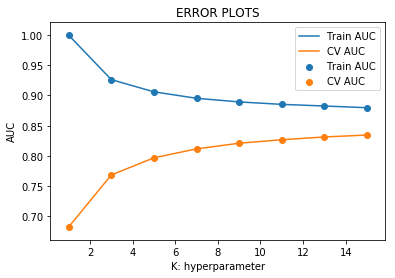

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'brute')
    neigh.fit(X_train_avgw2v, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_avgw2v)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_avgw2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='brute')

In [ ]:
knn.fit(X_train_avgw2v,Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test_avgw2v)
print(pred)

[1 0 1 ... 1 1 0]


In [ ]:
pred1 = neigh.predict(X_train_avgw2v)
print(pred1)

[1 0 1 ... 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[12088,  4258],
       [ 4944, 11710]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[18489,  4071],
       [ 5088, 17242]], dtype=int64)

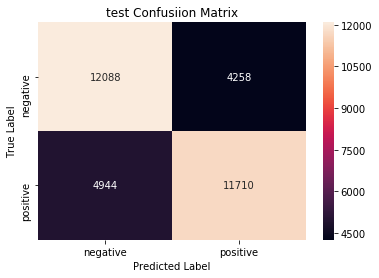

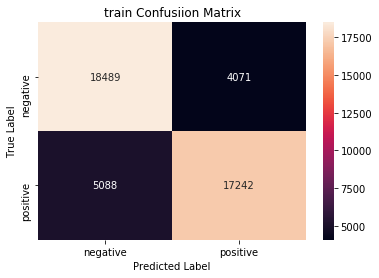

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     16346
           1       0.73      0.70      0.72     16654

   micro avg       0.72      0.72      0.72     33000
   macro avg       0.72      0.72      0.72     33000
weighted avg       0.72      0.72      0.72     33000

test classification report
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     22560
           1       0.81      0.77      0.79     22330

   micro avg       0.80      0.80      0.80     44890
   macro avg       0.80      0.80      0.80     44890
weighted avg       0.80      0.80      0.80     44890



#### form precision we can know that the model predicts positive and negative points nearly equal of both train and test data
#### f1 - scores of of both positive and negative points are equal in test data and nearly equal in train data

In [ ]:
from sklearn.metrics import roc_curve

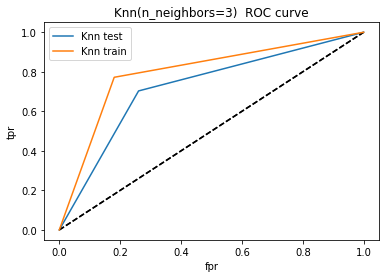

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### as roc curves of train and test are above the diagonal ,
#### we can say that both the test and train the model is better for both of them¶
#### it is slightly better for train data

#### auc of test data ~ 0.72
#### auc of train data ~ 0.79

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

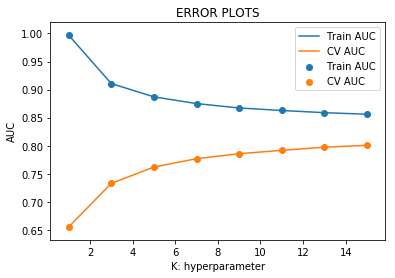

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'brute')
    neigh.fit(X_train_tfidfw2v, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_tfidfw2v)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_tfidfw2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='brute')

In [ ]:
knn.fit(X_train_tfidfw2v,Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test_tfidfw2v)
print(pred)

[0 0 0 ... 0 1 0]


In [ ]:
pred1 = neigh.predict(X_train_tfidfw2v)
print(pred1)

[1 1 1 ... 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[11381,  4965],
       [ 5327, 11327]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[17995,  4565],
       [ 5588, 16742]], dtype=int64)

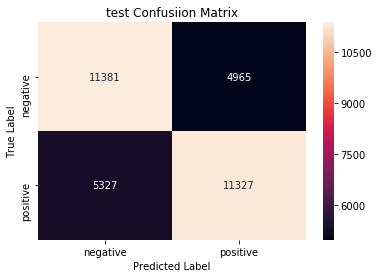

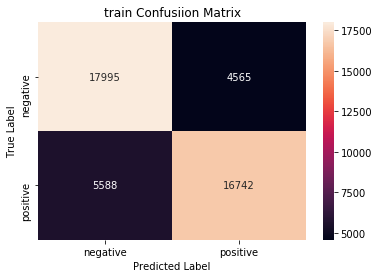

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     16346
           1       0.70      0.68      0.69     16654

   micro avg       0.69      0.69      0.69     33000
   macro avg       0.69      0.69      0.69     33000
weighted avg       0.69      0.69      0.69     33000

test classification report
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     22560
           1       0.79      0.75      0.77     22330

   micro avg       0.77      0.77      0.77     44890
   macro avg       0.77      0.77      0.77     44890
weighted avg       0.77      0.77      0.77     44890



#### form precision we can know that the model predicts positive and negative points nearly equal of both train and test data
#### f1 - scores of of both positive and negative points are equal in test data and nearly equal in train data

In [ ]:
from sklearn.metrics import roc_curve

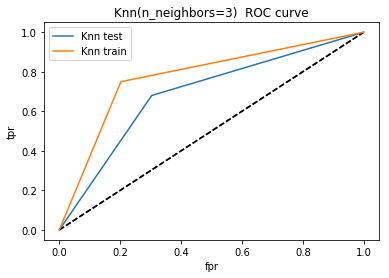

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### as roc curves of train and test are above the diagonal ,
#### we can say that both the test and train the model is better for both of them¶¶
#### it is slightly better for train data

#### auc of test data ~ 0.69
#### auc of train data ~ 0.78

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
X_train1 = svd.fit_transform(X_train_bow) 
X_cv1 = svd.transform(X_cv_bow)
X_test1 = svd.transform(X_test_bow) 

In [ ]:
X_train1.shape, X_cv1.shape, X_test1.shape

((44890, 5), (22110, 5), (33000, 5))

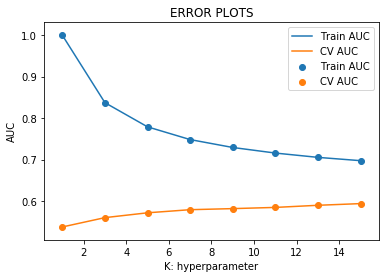

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'kd_tree')
    neigh.fit(X_train1, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train1)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv1)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='kd_tree')

In [ ]:
knn.fit(X_train1,Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test1)
print(pred)

[0 1 0 ... 0 0 1]


In [ ]:
pred1 = neigh.predict(X_train1)
print(pred1)

[1 1 1 ... 0 0 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[8864, 7482],
       [7535, 9119]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[14376,  8184],
       [ 7869, 14461]], dtype=int64)

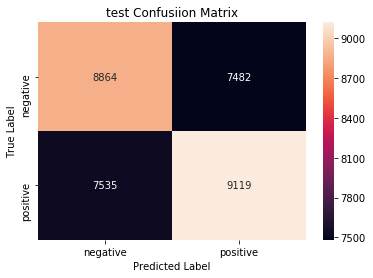

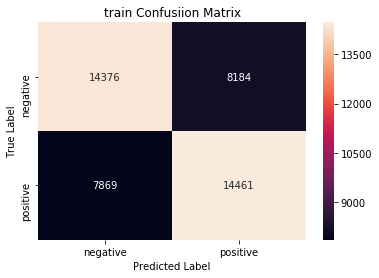

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     16346
           1       0.55      0.55      0.55     16654

   micro avg       0.54      0.54      0.54     33000
   macro avg       0.54      0.54      0.54     33000
weighted avg       0.54      0.54      0.54     33000

test classification report
              precision    recall  f1-score   support

           0       0.65      0.64      0.64     22560
           1       0.64      0.65      0.64     22330

   micro avg       0.64      0.64      0.64     44890
   macro avg       0.64      0.64      0.64     44890
weighted avg       0.64      0.64      0.64     44890



#### form precision we can know that the model predicts positive and negative points nearly equal of both train and test data
#### f1 - scores of of both positive and negative points are equal in train data and nearly equal in test data

In [ ]:
from sklearn.metrics import roc_curve

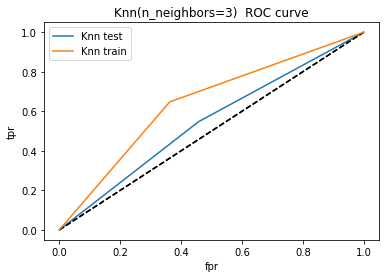

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### as roc curves of train and test are above the diagonal ,
#### we can say that both the test and train the model is better for both of them
#### test data is worse than train data

#### auc of test data ~ 0.55
#### auc of train data ~ 0.69

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
X_train2 = svd.fit_transform(X_train_tfidf) 
X_cv2 = svd.fit_transform(X_cv_tfidf)
X_test2 = svd.transform(X_test_tfidf) 

In [ ]:
X_train2.shape , X_cv2.shape ,X_test2.shape

((44890, 5), (22110, 5), (33000, 5))

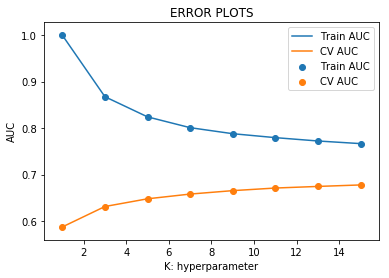

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'kd_tree')
    neigh.fit(X_train2, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train2)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv2)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='kd_tree')

In [ ]:
knn.fit(X_train2,Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test2)
print(pred)

[0 0 0 ... 1 1 0]


In [ ]:
pred1 = neigh.predict(X_train2)
print(pred1)

[0 0 1 ... 1 0 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[ 9385,  6961],
       [ 6308, 10346]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[15512,  7048],
       [ 6670, 15660]], dtype=int64)

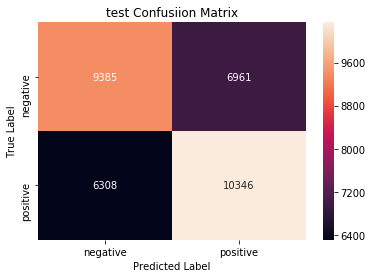

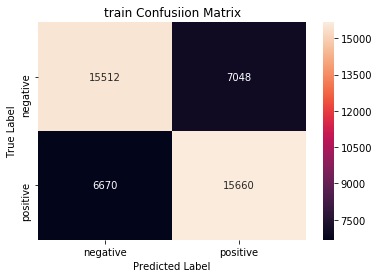

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     16346
           1       0.60      0.62      0.61     16654

   micro avg       0.60      0.60      0.60     33000
   macro avg       0.60      0.60      0.60     33000
weighted avg       0.60      0.60      0.60     33000

test classification report
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     22560
           1       0.69      0.70      0.70     22330

   micro avg       0.69      0.69      0.69     44890
   macro avg       0.69      0.69      0.69     44890
weighted avg       0.69      0.69      0.69     44890



#### form precision we can know that the model predicts positive and negative points equal of both train and test data
#### f1 - scores of of both positive and negative points are nearly equal in test data and nearly equal in train data

In [ ]:
from sklearn.metrics import roc_curve

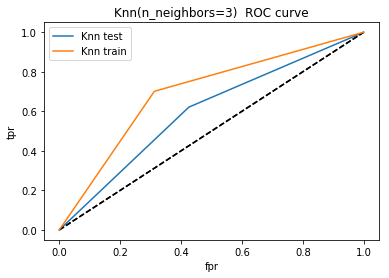

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### as roc curves of train and test are above the diagonal ,
#### we can say that both the test and train the model is better for both of them¶
#### train data is better than test data

#### auc of test data ~ 0.62
#### auc of train data ~ 0.75

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
X_train3 = svd.fit_transform(X_train_avgw2v) 
X_cv3 = svd.fit_transform(X_cv_avgw2v)
X_test3 = svd.transform(X_test_avgw2v)

In [ ]:
X_train3.shape , X_cv3.shape ,X_test3.shape

((44890, 5), (22110, 5), (33000, 5))

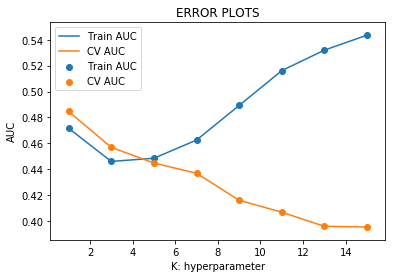

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'kd_tree')
    neigh.fit(X_train2, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train3)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv3)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='kd_tree')

In [ ]:
knn.fit(X_train3,Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test3)
print(pred)

[1 0 0 ... 0 0 1]


In [ ]:
pred1 = neigh.predict(X_train3)
print(pred1)

[1 1 0 ... 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[8628, 7718],
       [9076, 7578]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train, pred1)
cm1

array([[ 9999, 12561],
       [ 8339, 13991]], dtype=int64)

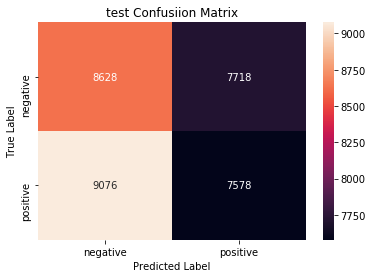

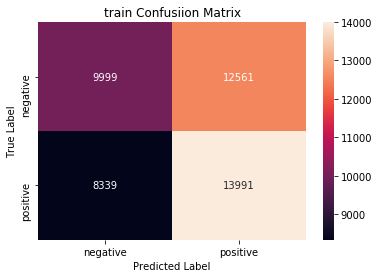

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.49      0.53      0.51     16346
           1       0.50      0.46      0.47     16654

   micro avg       0.49      0.49      0.49     33000
   macro avg       0.49      0.49      0.49     33000
weighted avg       0.49      0.49      0.49     33000

test classification report
              precision    recall  f1-score   support

           0       0.55      0.44      0.49     22560
           1       0.53      0.63      0.57     22330

   micro avg       0.53      0.53      0.53     44890
   macro avg       0.54      0.53      0.53     44890
weighted avg       0.54      0.53      0.53     44890



#### on looking at the recall , we can know that 
#### on train data 63% of the total positive points are plotted positive
#### on test data only 46% of the total positive points are plotted positive

In [ ]:
from sklearn.metrics import roc_curve

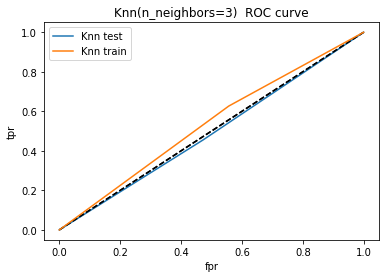

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### since the roc curve of test is below the diagonal , the model works worse on test data
#### since the roc curve of train is above the diagonal , the model works better on train data than on test data

#### auc of test data < 0.5
#### auc of train data ~ 0.62

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
X_train4 = svd.fit_transform(X_train_tfidfw2v) 
X_cv4 = svd.fit_transform(X_cv_tfidfw2v)
X_test4 = svd.transform(X_test_tfidfw2v)

In [ ]:
X_train4.shape , X_cv4.shape ,X_test4.shape

((44890, 5), (22110, 5), (33000, 5))

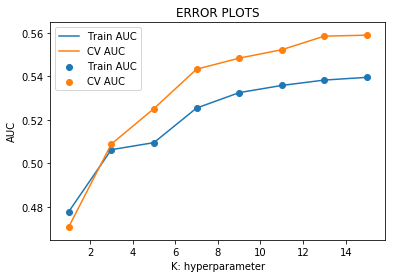

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 3, 5, 7, 9, 11, 13, 15]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = 'kd_tree')
    neigh.fit(X_train2, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train4)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv4)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
        
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

### k = 3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm ='kd_tree')

In [ ]:
knn.fit(X_train4,Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred = knn.predict(X_test4)
print(pred)

[0 0 1 ... 0 1 0]


In [ ]:
pred1 = neigh.predict(X_train4)
print(pred1)

[0 1 0 ... 1 0 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

array([[8894, 7452],
       [7514, 9140]], dtype=int64)

In [ ]:
cm1 = confusion_matrix(Y_train,pred1)
cm1

array([[10665, 11895],
       [ 9217, 13113]], dtype=int64)

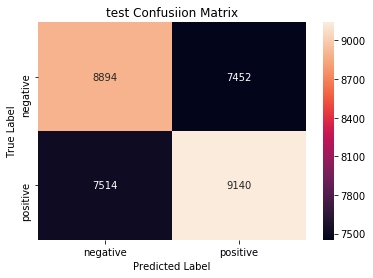

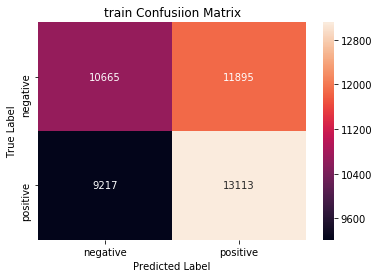

In [ ]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### typo error = the second table is of train classificatiion report 

In [ ]:
from sklearn.metrics import classification_report
print("test classification report")
print(classification_report(Y_test, pred))
print("test classification report")
print(classification_report(Y_train, pred1))

test classification report
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     16346
           1       0.55      0.55      0.55     16654

   micro avg       0.55      0.55      0.55     33000
   macro avg       0.55      0.55      0.55     33000
weighted avg       0.55      0.55      0.55     33000

test classification report
              precision    recall  f1-score   support

           0       0.54      0.47      0.50     22560
           1       0.52      0.59      0.55     22330

   micro avg       0.53      0.53      0.53     44890
   macro avg       0.53      0.53      0.53     44890
weighted avg       0.53      0.53      0.53     44890



#### both the test and train data works in similar manner and provides similar results

In [ ]:
from sklearn.metrics import roc_curve

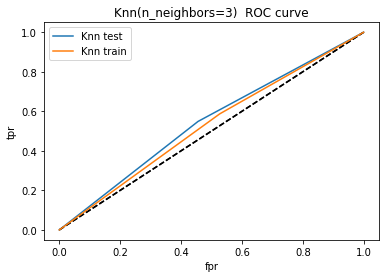

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn test')
fpr, tpr, thresholds = roc_curve(Y_train, pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=3)  ROC curve')
plt.show()

#### since thegap between roc curves of both test and train data are nearer to the diagonal,
#### this model does not provide good results

#### auc of test data ~ 0.55
#### auc of train data ~ 0.54

# [6] Conclusions

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model ","brute train auc", "brute test auc","kd_tree train auc", "kd_tree test auc"]
x.add_row([ "bag of words", 0.8, 0.89 ,0.55,0.69 ])
x.add_row( ["tfidf" ,0.7, 0.82 , 0.62, 0.75 ])
x.add_row([ "avg w2v", 0.72, 0.79 , "less than 0.5", 0.62 ])
x.add_row([ "tidfw2v", 0.69, 0.78 , 0.55, 0.54 ])
print("comparision of brute force models and kd_tree models")
print(x.get_string(title="comparision of brute force models and kd_tree models"))

comparision of brute force models and kd_tree models
+--------------+-----------------+----------------+-------------------+------------------+
|    model     | brute train auc | brute test auc | kd_tree train auc | kd_tree test auc |
+--------------+-----------------+----------------+-------------------+------------------+
| bag of words |       0.8       |      0.89      |        0.55       |       0.69       |
|    tfidf     |       0.7       |      0.82      |        0.62       |       0.75       |
|   avg w2v    |       0.72      |      0.79      |   less than 0.5   |       0.62       |
|   tidfw2v    |       0.69      |      0.78      |        0.55       |       0.54       |
+--------------+-----------------+----------------+-------------------+------------------+


##### references
##### kaggle , stack overflow , sklearn , github